In [627]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [628]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [629]:
from graphviz import Digraph

In [630]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in edges:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

In [631]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [632]:
a = Value(2.0, label='a')
b = Value(-5.0, label='b')
c = Value(7.0, label='c')
e = a + b; e.label = 'e'

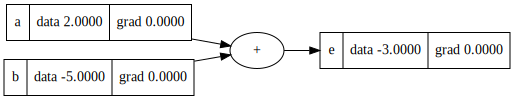

In [633]:
draw_dot(e)

In [634]:
e.grad = 1.0

In [635]:
e._backward()

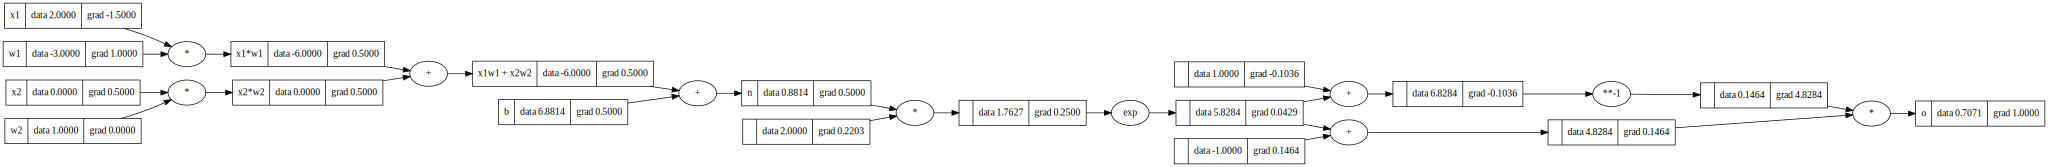

In [636]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [637]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # perform wx + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # activation function
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

n.parameters()

[Value(data=0.14186511697867976),
 Value(data=0.0800470780848972),
 Value(data=-0.26776208903654575),
 Value(data=-0.6836735994449632),
 Value(data=-0.5094500700598625),
 Value(data=0.692463081331405),
 Value(data=-0.9381216723052839),
 Value(data=-0.9408571740377571),
 Value(data=0.5956824133208474),
 Value(data=-0.4449882672549459),
 Value(data=0.13737105549573192),
 Value(data=0.09054830994344076),
 Value(data=0.2563658123305159),
 Value(data=-0.8650549047529152),
 Value(data=-0.1775305709371804),
 Value(data=0.4874336668935477),
 Value(data=0.0320673406278964),
 Value(data=0.4739928806698528),
 Value(data=0.9498950268560806),
 Value(data=-0.47824312227610566),
 Value(data=0.8193452502746883),
 Value(data=0.8454446291778406),
 Value(data=0.7975213256969382),
 Value(data=-0.42871904835518393),
 Value(data=-0.6680370245532086),
 Value(data=-0.33601624355572546),
 Value(data=-0.326587474805653),
 Value(data=-0.9347745409139314),
 Value(data=0.06655914507640515),
 Value(data=0.732891079

In [638]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [669]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.006591640671383871)

In [670]:
loss.backward()

In [671]:
for p in n.parameters():
    p.data += -0.005 * p.grad

In [673]:
ys

[1.0, -1.0, -1.0, 1.0]

In [674]:
ypred

[Value(data=0.9993612393043031),
 Value(data=-0.9215165395813333),
 Value(data=-0.9854767409510816),
 Value(data=0.9851455715873316)]

In [675]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 0.004802794935632407
1 0.004456999195493378
2 0.004159009991721405
3 0.0038995222403208863
4 0.003671501071881862
5 0.003469528407447012
6 0.003289363259643552
7 0.003127638303185356
8 0.0029816458020305386
9 0.002849183594789746
10 0.002728442339428336
11 0.0026179216620434956
12 0.0025163669131855445
13 0.0024227208518074997
14 0.0023360862996115485
15 0.0022556969644927415
16 0.0021808944209768463
17 0.002111109782970434
18 0.002045848989430339
19 0.0019846808983995045
